# CVE Published to KEV Added Date - Trend and Factors

### Get the Required Data. First, the CVE Data from NVD.

In [1]:
# Download and extract data
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json
!rm *.zip
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2000..2024}.json.zip
!unzip -o "*.zip"

In [2]:
#import libraries
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import LabelEncoder
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#data extraction process
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'BaseScore': base_score,
                'Description': description,
            }
            if not description.startswith('Rejected reason'):
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

In [4]:
# change the published date to datetime
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvd['Published'] = pd.to_datetime(nvd['Published'], errors='coerce')
nvd = nvd.sort_values('Published')

In [5]:
# verify the start and end date of the cve published date
oldest_date = nvd['Published'].min()
newest_date = nvd['Published'].max()
print(f'Oldest date: {oldest_date}')
print(f'Newest date: {newest_date}')

Oldest date: 1988-10-01 00:00:00
Newest date: 2024-01-17 00:00:00


In [6]:
print(nvd.head())

                CVE  Published BaseScore  \
93    CVE-1999-0095 1988-10-01       0.0   
80    CVE-1999-0082 1988-11-11       0.0   
1417  CVE-1999-1471 1989-01-01       0.0   
1069  CVE-1999-1122 1989-07-26       0.0   
1413  CVE-1999-1467 1989-10-26       0.0   

                                            Description  
93    The debug command in Sendmail is enabled, allo...  
80        CWD ~root command in ftpd allows root access.  
1417  Buffer overflow in passwd in BSD based operati...  
1069  Vulnerability in restore in SunOS 4.0.3 and ea...  
1413  Vulnerability in rcp on SunOS 4.0.x allows rem...  


In [7]:
print(len(nvd))

222367


## Get the data from KEV

In [8]:
url_kev = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
kev = pd.read_csv(url_kev, header=0)

In [9]:
print(kev.head())

            cveID vendorProject             product  \
0  CVE-2021-27104     Accellion                 FTA   
1  CVE-2021-27102     Accellion                 FTA   
2  CVE-2021-27101     Accellion                 FTA   
3  CVE-2021-27103     Accellion                 FTA   
4  CVE-2021-21017         Adobe  Acrobat and Reader   

                                   vulnerabilityName   dateAdded  \
0   Accellion FTA OS Command Injection Vulnerability  2021-11-03   
1   Accellion FTA OS Command Injection Vulnerability  2021-11-03   
2          Accellion FTA SQL Injection Vulnerability  2021-11-03   
3  Accellion FTA Server-Side Request Forgery (SSR...  2021-11-03   
4  Adobe Acrobat and Reader Heap-based Buffer Ove...  2021-11-03   

                                    shortDescription  \
0  Accellion FTA contains an OS command injection...   
1  Accellion FTA contains an OS command injection...   
2  Accellion FTA contains a SQL injection vulnera...   
3  Accellion FTA contains a server-s

###Build a Consolidated Dataframe (KEV Left Joined with CVE)

In [10]:
kev_extended = pd.merge(kev, nvd,left_on='cveID', right_on='CVE', how='left')

In [11]:
kev_extended.tail()

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes,CVE,Published,BaseScore,Description
1063,CVE-2024-21887,Ivanti,Connect Secure and Policy Secure,Ivanti Connect Secure and Policy Secure Comman...,2024-01-10,"Ivanti Connect Secure (ICS, formerly known as ...",Apply mitigations per vendor instructions or d...,2024-01-22,Unknown,Please apply mitigations per vendor instructio...,CVE-2024-21887,2024-01-12,9.1,A command injection vulnerability in web compo...
1064,CVE-2018-15133,Laravel,Laravel Framework,Laravel Deserialization of Untrusted Data Vuln...,2024-01-16,Laravel Framework contains a deserialization o...,Apply mitigations per vendor instructions or d...,2024-02-06,Unknown,https://laravel.com/docs/5.6/upgrade#upgrade-5...,CVE-2018-15133,2018-08-09,8.1,In Laravel Framework through 5.5.40 and 5.6.x ...
1065,CVE-2024-0519,Google,Chromium V8,Google Chromium V8 Out-of-Bounds Memory Access...,2024-01-17,Google Chromium V8 contains an out-of-bounds m...,Apply mitigations per vendor instructions or d...,2024-02-07,Unknown,https://chromereleases.googleblog.com/2024/01/...,CVE-2024-0519,2024-01-16,0.0,Out of bounds memory access in V8 in Google Ch...
1066,CVE-2023-6549,Citrix,NetScaler ADC and NetScaler Gateway,Citrix NetScaler ADC and NetScaler Gateway Buf...,2024-01-17,Citrix NetScaler ADC and NetScaler Gateway con...,Apply mitigations per vendor instructions or d...,2024-02-07,Unknown,https://support.citrix.com/article/CTX584986/n...,NaN,NaT,NaN,NaN
1067,CVE-2023-6548,Citrix,NetScaler ADC and NetScaler Gateway,Citrix NetScaler ADC and NetScaler Gateway Cod...,2024-01-17,Citrix NetScaler ADC and NetScaler Gateway con...,Apply mitigations per vendor instructions or d...,2024-01-24,Unknown,https://support.citrix.com/article/CTX584986/n...,NaN,NaT,NaN,NaN


## Prepare the Data for Analysis

In [12]:
# change datatype
kev_extended['Published'] = pd.to_datetime(kev_extended['Published'])
kev_extended['Published'] = pd.to_datetime(kev_extended['Published']).apply(lambda x: x.date())
kev_extended['Published'] = pd.to_datetime(kev_extended['Published'], errors='coerce')

In [13]:
# change datatype
kev_extended['dateAdded'] = pd.to_datetime(kev_extended['dateAdded'])
kev_extended['dateAdded'] = pd.to_datetime(kev_extended['dateAdded']).apply(lambda x: x.date())
kev_extended['dateAdded'] = pd.to_datetime(kev_extended['dateAdded'], errors='coerce')

In [14]:
# Calculate Time Difference in Days
kev_extended['daystokev'] = (kev_extended['dateAdded'] - kev_extended['Published']).dt.days

In [15]:
# Assuming 'Published' column contains datetime information
kev_extended['Publishedmonth'] = kev_extended['Published'].dt.month
kev_extended['YearMonth'] = kev_extended['dateAdded'].dt.to_period("M")

Visualize the Distribution

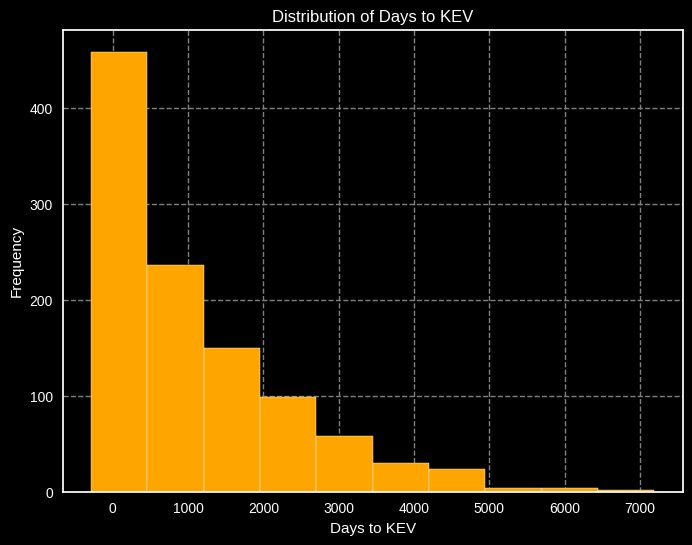

In [16]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.hist(kev_extended['daystokev'], bins=10, color = "orange", edgecolor="white")
plt.xlabel("Days to KEV", color="white")
plt.ylabel("Frequency", color="white")
plt.title("Distribution of Days to KEV", color="white")
plt.grid(color="gray", linestyle="--")
plt.show()

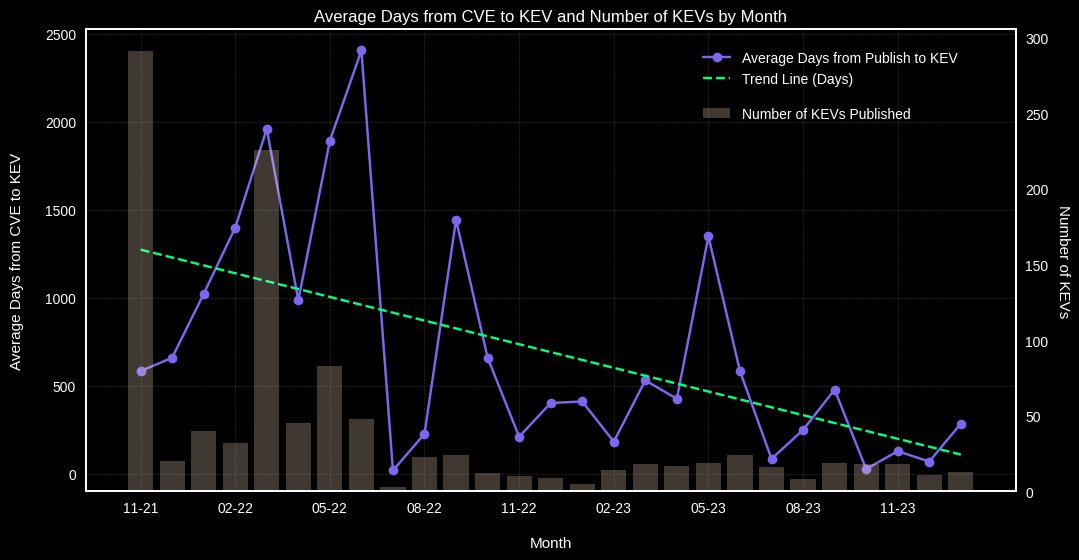

In [17]:
# Set dark mode for the plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6))

# Group data by month and calculate the mean of 'daystoekev' and count of KEVs for each month
monthly_data = kev_extended.groupby('YearMonth')['daystokev'].mean()
monthly_count = kev_extended.groupby('YearMonth')['CVE'].count()

# Format the period index to display in mm-yy format
formatted_index = monthly_data.index.strftime('%m-%y')

# Create the line graph for 'daystokev'
ax.plot(formatted_index, monthly_data, color="mediumslateblue", marker='o', label="Average Days from Publish to KEV")

# Fit a linear regression line for 'daystokev'
z = np.polyfit(np.arange(len(monthly_data)), monthly_data, 1)
p = np.poly1d(z)

# Add the trend line for 'daystoexploit' to the plot
ax.plot(formatted_index, p(np.arange(len(monthly_data))), color="springgreen", linestyle="--", label="Trend Line (Days)")

# Create a secondary y-axis for the count of KEVs
ax2 = ax.twinx()
ax2.bar(formatted_index, monthly_count, alpha=0.25, color="bisque", label="Number of KEVs Published")

# Customize plot elements for better visibility in dark mode
ax.set_xlabel("Month", color="white", labelpad=15)
ax.set_ylabel("Average Days from CVE to KEV", color="white", rotation=90, labelpad=15)
ax2.set_ylabel("Number of KEVs", color="white", rotation=270, labelpad=15)
ax.set_title("Average Days from CVE to KEV and Number of KEVs by Month", color="white")
ax.grid(axis='y', linestyle='--', alpha=0.2, color='lightgrey', linewidth=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.2, color='lightgrey', linewidth=0.5)
ax2.grid(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.65, 0.98))
ax2.legend(loc="upper left", bbox_to_anchor=(0.65, 0.86))
plt.xticks(formatted_index[::3])
plt.show()

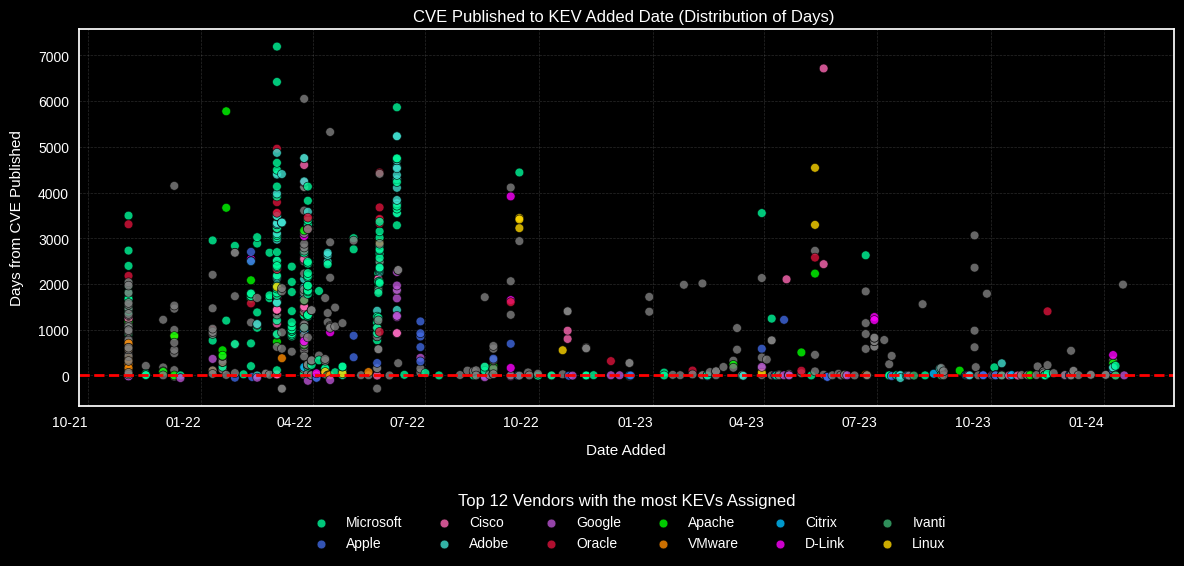

In [18]:
plt.figure(figsize=(12, 6))

# Define six distinct colors
distinct_colors = color_names = ['mediumspringgreen', 'royalblue', 'hotpink', 'turquoise', 'mediumorchid', 'crimson', 'lime', 'darkorange', 'deepskyblue','magenta', 'mediumseagreen', 'gold', 'mediumslateblue', 'springgreen',
    'mediumseagreen', 'darkorange', 'paleturquoise', 'mediumvioletred', 'deepskyblue', 'coral', 'limegreen', 'dodgerblue', 'blueviolet', 'darkturquoise', 'darkorchid', 'khaki', 'orangered', 'mediumturquoise', 'mediumpurple',
    'indianred', 'lightgreen', 'lightseagreen', 'orange', 'violet', 'tomato', 'orangered', 'peachpuff', 'aqua', 'mediumorchid', 'darkmagenta', 'darkorange', 'wheat', 'mediumblue', 'mediumorchid', 'darkviolet']

if pd.api.types.is_string_dtype(kev_extended['vendorProject']):
    kev_extended['vendorProject'] = kev_extended['vendorProject'].astype('category')

# Get the top 12 categories by count
top_categories = kev_extended['vendorProject'].value_counts().nlargest(12).index

# Create a dictionary to map categories to unique colors
category_colors = {category: color for category, color in zip(top_categories, distinct_colors)}

# Map colors to each data point
colors = kev_extended['vendorProject'].map(category_colors).combine_first(pd.Series(['gray'] * len(kev_extended), index=kev_extended.index))

scatter = plt.scatter(kev_extended['dateAdded'], kev_extended['daystokev'], c=colors, s=40, edgecolors='black', linewidth=0.5, alpha=0.8)

# Add a line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.xlabel("Date Added", labelpad=10)
plt.ylabel("Days from CVE Published", labelpad=10)
plt.title("CVE Published to KEV Added Date (Distribution of Days) ")

# Format x-axis as 'mm-yy'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))


legend_handles = [plt.scatter([], [], label=category, color=[color], edgecolors='black', linewidth=0.5, s=40, alpha=0.8) for category, color in category_colors.items()]
plt.legend(handles=legend_handles, title="Top 12 Vendors with the most KEVs Assigned", bbox_to_anchor=(0.50, -0.2), loc='upper center', ncol=6)
plt.grid(axis='y', linestyle='--', alpha=0.2, color='lightgrey', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.2, color='lightgrey', linewidth=0.5)

plt.xticks(rotation=0, ha='right')

plt.tight_layout()
plt.show()

In [19]:
len(kev_extended)

1068

In [20]:
len(kev_extended[kev_extended['daystokev'] == 0])

42

In [21]:
kev.tail(10)

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes
1058,CVE-2023-27524,Apache,Superset,Apache Superset Insecure Default Initializatio...,2024-01-08,Apache Superset contains an insecure default i...,Apply mitigations per vendor instructions or d...,2024-01-29,Unknown,https://lists.apache.org/thread/n0ftx60sllf527...
1059,CVE-2023-29300,Adobe,ColdFusion,Adobe ColdFusion Deserialization of Untrusted ...,2024-01-08,Adobe ColdFusion contains a deserialization of...,Apply mitigations per vendor instructions or d...,2024-01-29,Unknown,https://helpx.adobe.com/security/products/cold...
1060,CVE-2023-38203,Adobe,ColdFusion,Adobe ColdFusion Deserialization of Untrusted ...,2024-01-08,Adobe ColdFusion contains a deserialization of...,Apply mitigations per vendor instructions or d...,2024-01-29,Unknown,https://helpx.adobe.com/security/products/cold...
1061,CVE-2023-29357,Microsoft,SharePoint Server,Microsoft SharePoint Server Privilege Escalati...,2024-01-10,Microsoft SharePoint Server contains an unspec...,Apply mitigations per vendor instructions or d...,2024-01-31,Unknown,https://msrc.microsoft.com/update-guide/vulner...
1062,CVE-2023-46805,Ivanti,Connect Secure and Policy Secure,Ivanti Connect Secure and Policy Secure Authen...,2024-01-10,"Ivanti Connect Secure (ICS, formerly known as ...",Apply mitigations per vendor instructions or d...,2024-01-22,Unknown,Please apply mitigations per vendor instructio...
1063,CVE-2024-21887,Ivanti,Connect Secure and Policy Secure,Ivanti Connect Secure and Policy Secure Comman...,2024-01-10,"Ivanti Connect Secure (ICS, formerly known as ...",Apply mitigations per vendor instructions or d...,2024-01-22,Unknown,Please apply mitigations per vendor instructio...
1064,CVE-2018-15133,Laravel,Laravel Framework,Laravel Deserialization of Untrusted Data Vuln...,2024-01-16,Laravel Framework contains a deserialization o...,Apply mitigations per vendor instructions or d...,2024-02-06,Unknown,https://laravel.com/docs/5.6/upgrade#upgrade-5...
1065,CVE-2024-0519,Google,Chromium V8,Google Chromium V8 Out-of-Bounds Memory Access...,2024-01-17,Google Chromium V8 contains an out-of-bounds m...,Apply mitigations per vendor instructions or d...,2024-02-07,Unknown,https://chromereleases.googleblog.com/2024/01/...
1066,CVE-2023-6549,Citrix,NetScaler ADC and NetScaler Gateway,Citrix NetScaler ADC and NetScaler Gateway Buf...,2024-01-17,Citrix NetScaler ADC and NetScaler Gateway con...,Apply mitigations per vendor instructions or d...,2024-02-07,Unknown,https://support.citrix.com/article/CTX584986/n...
1067,CVE-2023-6548,Citrix,NetScaler ADC and NetScaler Gateway,Citrix NetScaler ADC and NetScaler Gateway Cod...,2024-01-17,Citrix NetScaler ADC and NetScaler Gateway con...,Apply mitigations per vendor instructions or d...,2024-01-24,Unknown,https://support.citrix.com/article/CTX584986/n...


In [22]:
kev_extended.dtypes

cveID                                 object
vendorProject                       category
product                               object
vulnerabilityName                     object
dateAdded                     datetime64[ns]
shortDescription                      object
requiredAction                        object
dueDate                               object
knownRansomwareCampaignUse            object
notes                                 object
CVE                                   object
Published                     datetime64[ns]
BaseScore                             object
Description                           object
daystokev                            float64
Publishedmonth                       float64
YearMonth                          period[M]
dtype: object

In [23]:
kev_extended['base_score'] = kev_extended['BaseScore'].astype(float)

### Plot a Regression Line

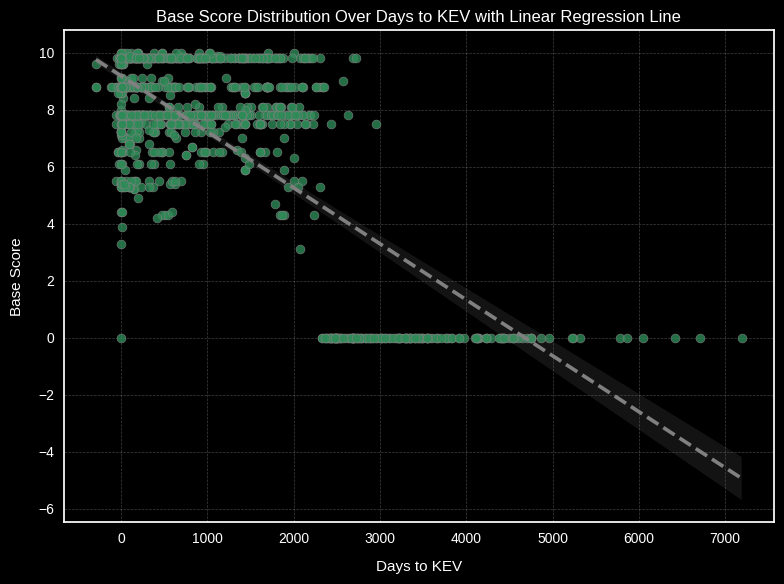

In [24]:
plt.style.use('dark_background')

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='daystokev', y='base_score', data=kev_extended, color='seagreen', marker='o', s=40, edgecolor='grey', linewidth=0.5, alpha=0.8)
sns.regplot(x='daystokev', y='base_score', data=kev_extended, scatter=False, color='grey', line_kws={'linestyle': '--'})

plt.xlabel("Days to KEV", labelpad=10)
plt.ylabel("Base Score", labelpad=10)
plt.title("Base Score Distribution Over Days to KEV with Linear Regression Line")
plt.grid(axis='y', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)


plt.tight_layout()
plt.show()

## Cluster Analysis

In [25]:
encoder = LabelEncoder()

In [26]:
kev_extended['encoded_vendor'] = encoder.fit_transform(kev_extended['vendorProject'])
kev_extended['encoded_knownattack'] = encoder.fit_transform(kev_extended['knownRansomwareCampaignUse'])

In [27]:
scaler = StandardScaler()
kev_scaled = scaler.fit_transform(kev_extended[['daystokev', 'base_score', 'encoded_vendor']])
kev_scaled = np.where(np.isnan(kev_scaled), 0, kev_scaled)

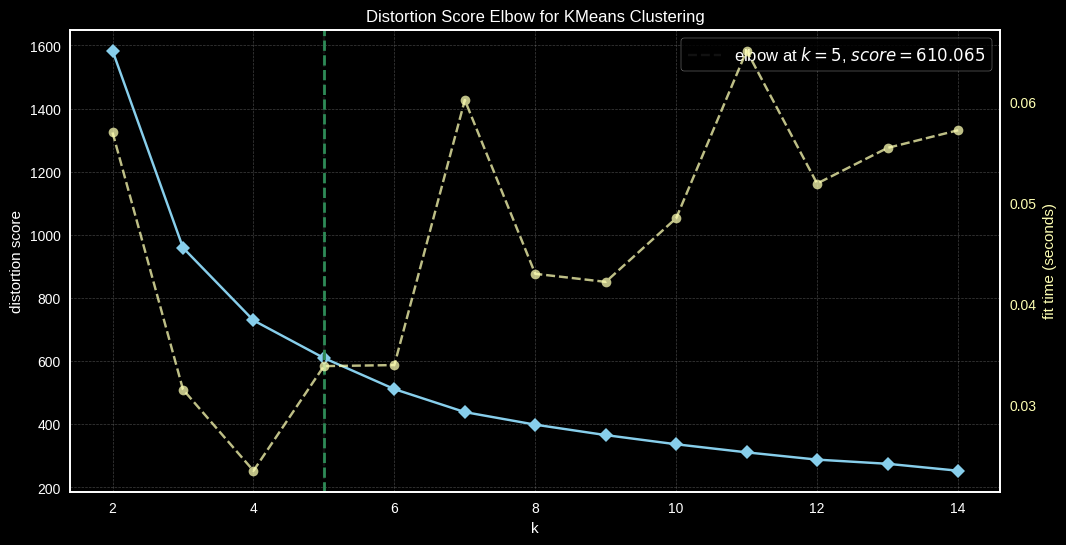

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 15))
visualizer.fit(kev_scaled)
visualizer.ax.grid(axis='x', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)
visualizer.ax.grid(axis='y', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)
visualizer.ax.axvline(x=visualizer.elbow_value_, color='seagreen', linestyle='--', linewidth=2)
visualizer.ax.lines[0].set_color('skyblue')
visualizer.show()

### Cluster Visualization

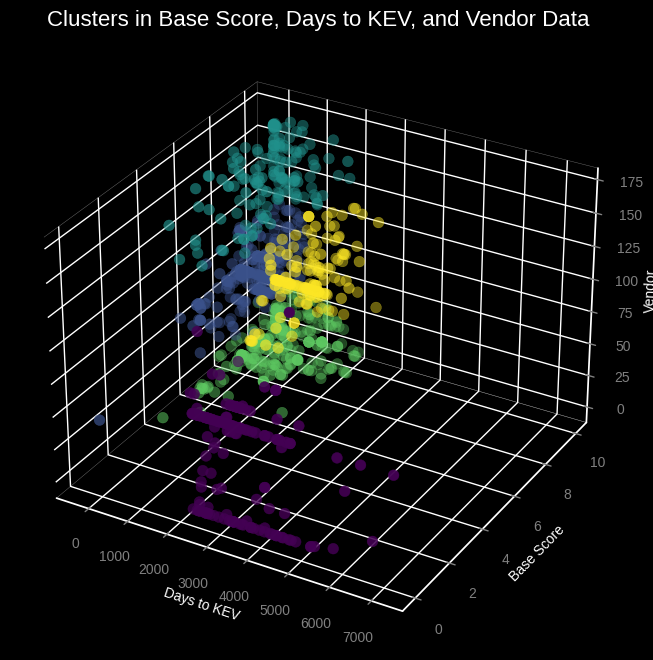

In [29]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
optimal_k = visualizer.elbow_value_

kmeans = KMeans(n_clusters=optimal_k, n_init=10)
clusters = kmeans.fit_predict(kev_scaled)

# Plot clusters with 3 axis
scatter = ax.scatter(kev_extended['daystokev'], kev_extended['base_score'], kev_extended['encoded_vendor'], c=clusters, cmap='viridis', s=60)

ax.grid(axis='x', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)
ax.grid(axis='y', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)
ax.grid(axis='z', linestyle='--', alpha=0.3, color='lightgrey', linewidth=0.5)

# Customize tick parameters
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.tick_params(axis='z', colors='grey')

# Customize plot area color
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


ax.set_xlabel("Days to KEV", labelpad=5, fontsize = 10)
ax.set_ylabel("Base Score", labelpad=5, fontsize = 10)
ax.set_zlabel("Vendor", labelpad=5, fontsize = 10)
ax.set_title("Clusters in Base Score, Days to KEV, and Vendor Data", color = 'white', fontsize = 16)
ax.view_init(elev=30,azim=-60)

In [30]:
# Add cluster assignments to the original data
nvd_clusters = pd.DataFrame(kev_extended, columns=['cveID', 'vendorProject', 'daystokev', 'Publishedmonth', 'base_score', 'knownRansomwareCampaignUse'])
nvd_clusters['cluster'] = clusters

In [31]:
nvd_clusters.to_csv('nvd_clusters.csv', index=False)

In [32]:
from google.colab import files

In [33]:
files.download('nvd_clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Analyze cluster composition
cluster_composition = nvd_clusters.groupby('cluster').size()
print("Cluster Composition:")
print(cluster_composition)

Cluster Composition:
cluster
0    165
1    291
2    160
3    289
4    163
dtype: int64


In [35]:
# Analyze cluster characteristics (e.g., mean of features)
cluster_means = nvd_clusters.groupby('cluster').mean()
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
           daystokev  Publishedmonth  base_score
cluster                                         
0        3437.175758        6.515152    0.018788
1         226.786942        6.563574    8.105155
2         446.606250        5.793750    8.583750
3         709.372822        6.564460    8.485017
4        1570.380368        6.202454    8.209202


<ipython-input-35-d4d304ba8550>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = nvd_clusters.groupby('cluster').mean()


In [36]:
nvd_clusters.head()

,cveID,vendorProject,daystokev,Publishedmonth,base_score,knownRansomwareCampaignUse,cluster
0,CVE-2021-27104,Accellion,260.0,2.0,9.8,Known,3
1,CVE-2021-27102,Accellion,260.0,2.0,7.8,Known,3
2,CVE-2021-27101,Accellion,260.0,2.0,9.8,Known,3
3,CVE-2021-27103,Accellion,260.0,2.0,9.8,Known,3
4,CVE-2021-21017,Adobe,265.0,2.0,8.8,Unknown,3


### Explore Linear Influencers and Interactions

In [37]:
linear_check = 'daystokev ~ vendorProject * Publishedmonth'
lr_model = smf.ols(formula = linear_check, data=kev_extended).fit()

# Print the summary to analyze the factors
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:              daystokev   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     2.257
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           2.99e-17
Time:                        02:21:19   Log-Likelihood:                -8841.0
No. Observations:                1066   AIC:                         1.816e+04
Df Residuals:                     828   BIC:                         1.934e+04
Df Model:                         237                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [38]:
# Filter High Influence Factors
filtered_results = lr_model.params[(lr_model.pvalues < 0.05) & (abs(lr_model.params) > 0.7)]
filtered_results

Intercept                                                 955.416985
vendorProject[T.Adobe]                                   1833.332980
vendorProject[T.Alcatel]                                   91.426335
vendorProject[T.Apache]                                  1291.327099
vendorProject[T.Arcserve]                                 125.966365
vendorProject[T.Code Aurora]                               73.280784
vendorProject[T.GNU]                                    25428.583015
vendorProject[T.Hewlett Packard (HP)]                      82.365359
vendorProject[T.ImageMagick]                              107.350980
vendorProject[T.InduSoft]                                 196.906881
vendorProject[T.OpenSSL]                                  199.083352
vendorProject[T.Oracle]                                  1316.986002
vendorProject[T.PHP]                                     5375.583015
vendorProject[T.Realtek]                                 7047.416348
vendorProject[T.Rejetto]          